*All of the code in this notebook is done to maxmise clarity.  
For more beautiful and optimised code, please check the implemenetation of the classes and analysing functions.*

# Initialisation
Import the necessary class and define the constants for the Oslo Model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import analysis
from scipy.optimize import curve_fit, minimize
from collections import OrderedDict
from pile import Pile

# CONSTANTS
POSSIBLE_THRESHOLD_SLOPES = (1, 2)
OSLO_PROBS = (0.5, 0.5)

# Task 1
## Threshold Slopes Test
Create some length 16 piles with different values of $p$:

In [2]:
probs1 = (1, 0)  # p = 1
probs2 = (0, 1)  # p = 0

pile1 = Pile(16, probs1, POSSIBLE_THRESHOLD_SLOPES, name="BTW pile, length 16")
pile2 = Pile(16, probs2, POSSIBLE_THRESHOLD_SLOPES)

oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES, name="Oslo pile, length 16")

All threshold slopes of *pile1* should be 1:

In [3]:
pile1.get_threshold_slopes()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

All threshold slopes of *pile2* should be 2:

In [4]:
pile2.get_threshold_slopes()

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Around half of the threshold slopes in *oslo_pile_xs* should be 1, and the other half should be 2:

In [5]:
oslo_pile_xs.get_threshold_slopes()

[2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2]

## BTW vs. Oslo Test
Note that *pile1* with $p = 1$ is the BTW model. We can recover its 1D recurrent configuration (staircase) by dropping enough grains on to the pile:

In [6]:
for _ in range(500):
    pile1.drop_grain()
    
pile1.get_heights()

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

At the stable state, dropping a grain to the *i*th site of the pile will result in an avalanche size of $s = L - i$, where $s$ is the avalanche size, $L$ the length of the pile.

In [7]:
# i = 0
pile1.drop_grain()
pile1.ava_size

16

In [8]:
# i = 6
pile1.drop_grain(site_index=6)
pile1.ava_size

10

Now we try the same thing with the Oslo pile:

In [9]:
for _ in range(500):
    oslo_pile_xs.drop_grain()
    
oslo_pile_xs.get_heights()

[27, 25, 23, 23, 21, 19, 17, 15, 13, 12, 10, 9, 7, 5, 4, 2]

Finally, we compare the pile heights of the two piles versus time (number of grains dropped):

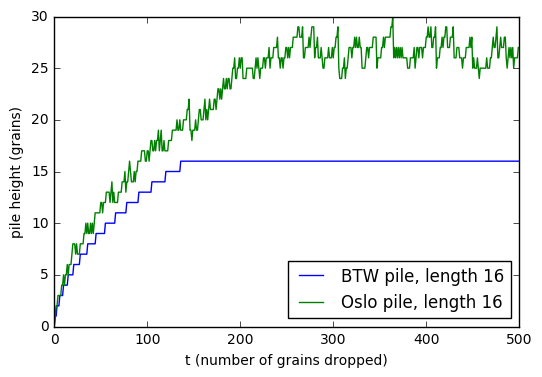

In [10]:
# reinitialise the piles
pile1.reset()
oslo_pile_xs.reset()

for i in (pile1, oslo_pile_xs):
    pile_heights = []
    
    # drop 500 grains
    for t in range(500):
        pile_heights.append(i.get_pile_height())
        i.drop_grain()
    plt.plot(pile_heights, label=i.name)
    
plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0)
plt.show()

Arriving the recurring configurations, we can keep dropping grains to the *oslo_pile_xs* and the pile height should average to $\langle h \rangle=26.5$.

In [11]:
pile_heights = []

for i in range(10000):
    oslo_pile_xs.drop_grain()
    pile_heights.append(oslo_pile_xs.get_pile_height())
    
np.average(pile_heights)

26.543800000000001

As we can see, the Oslo model exhibits very different behaviours to the BTW model.  
These tests have also sufficiently proved the correctness of the program.

---

# Task 2a

## Save/load Data
We first save the simulation data to a file, as simulating large system requires a lot of computational time.
The pile reaches a steady state when the last site topples. We can use this property to determine the amount of grains to drop.

~~~python

# Initialise piles
oslo_pile_xxs = Pile(8, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_s = Pile(32, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_m = Pile(64, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_l = Pile(128, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xl = Pile(256, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xxl = Pile(512, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)

piles = (oslo_pile_xxs, oslo_pile_xs, oslo_pile_s, oslo_pile_m, oslo_pile_l, oslo_pile_xl, oslo_pile_xxl)
data_dict = OrderedDict()

# Populate piles
for pile in piles:
    pile_dict = {'heights': [], 'avalanche size': []}

    while not pile.is_at_steady_state:
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    for _ in range(1000000):
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    data_dict[pile.length] = pile_dict

pickle.dump(data_dict, open('height_and_avalanche_data', 'wb'))
    
~~~

When the pile reaches a steady state, we drop 1,000,000 more grains for later analysis. 

We can then load the data back into program:

In [12]:
data_dict = pickle.load(open('height_and_avalanche_data', 'rb'))
steady_state_time_period = 1000000

## Height vs. Time Plots
**Plot the pile height against time (number of grains dropped):**

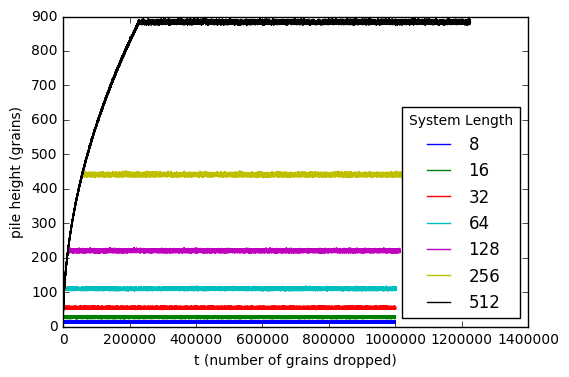

In [13]:
for length, pile_dict in data_dict.items():
    plt.plot(pile_dict['heights'], label=length)

plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0, title="System Length")
plt.show()

**As we can see, the height of the piles initially follows a curve. This is when the pile is still in transient configurations. At certain times, the heights flatten, denoting the corresponding piles reaching recurrent configurations.** 

**To get a rough estimation of the cross-over times $(t_c(L))$, and pile height in the steady state $(h_c(L))$, we first find the moving average of the data and display them on a log-log plot:**

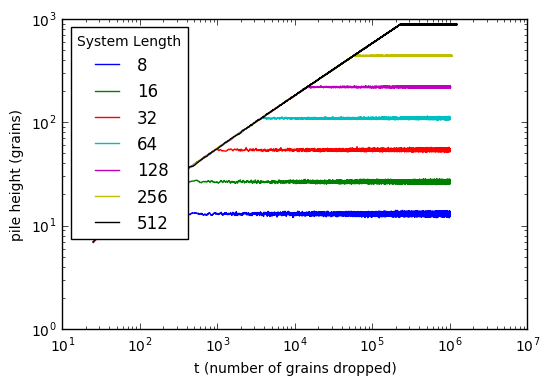

In [14]:
temporal_window = 50
start_time = int(temporal_window / 2)

for length, pile_dict in data_dict.items():
    smooth_data = analysis.np_moving_average(pile_dict['heights'], temporal_window)
    times = np.arange(start_time, len(smooth_data) + start_time)
    plt.loglog(times, smooth_data, label=length)

plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0, title="System Length")
plt.show()

**We can then estimate the values by finding the intercepts of the lines.**  

**With these datapoints, we can determine the relationships:**

$$t_c(L) \propto L^2$$  
$$h_c(L) \propto L$$

# Task 2b

## Data Collapse
_[INSERT THOERY]_

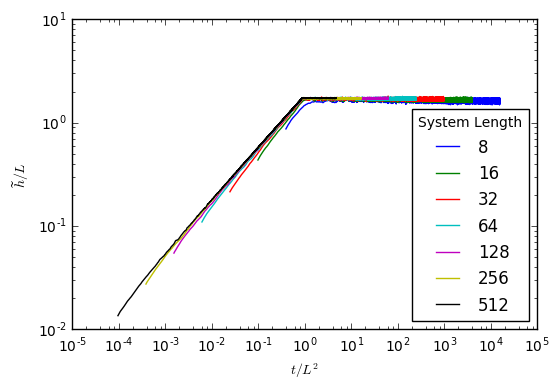

In [15]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.np_moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.loglog(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.xlabel("$t/L^2$")
plt.ylabel("$\widetilde h/L$")
plt.legend(loc=0, title="System Length")
plt.show()

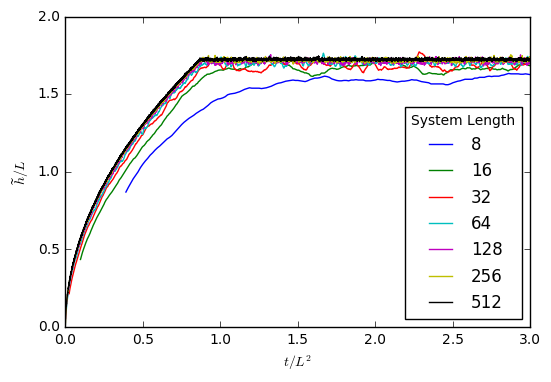

In [16]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.np_moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.plot(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.xlim(0, 3)
plt.xlabel("$t/L^2$")
plt.ylabel("$\widetilde h/L$")
plt.legend(loc=0, title="System Length")
plt.show()

$$\widetilde h\left(t; L\right) = L^{1}\mathcal{F}\left(\frac{t}{L^2}\right)$$  

As the system size tends to $\infty$, $\mathcal{F}(x)$ is discountinous at $x=1$. For $x < 1$, $\mathcal{F}(x)$ follows a power law. For $x \geqslant 1$, $\mathcal{F}(x)$ is constant.  

This is because the system experiences a phase trasition from the trasient state to the recurrent state, indicated by the non-zero outflux. 

_outflux order parameter :)_

We can fit the curve to find how $\widetilde h\left(t; L\right)$ relates to $t$ in the transient state:

In [121]:
power_law = lambda t, a, p: a * t ** p

starting_t = 1000
height_data = data_dict[512]['heights'][starting_t:-steady_state_time_period]
t = np.arange(starting_t, len(height_data) + starting_t)
(a, p), cov = curve_fit(power_law, t, height_data)
a, p, cov

(1.7702056565687259,
 0.50356741637914126,
 array([[  6.40178133e-08,  -3.05143918e-09],
        [ -3.05143918e-09,   1.45705666e-10]]))

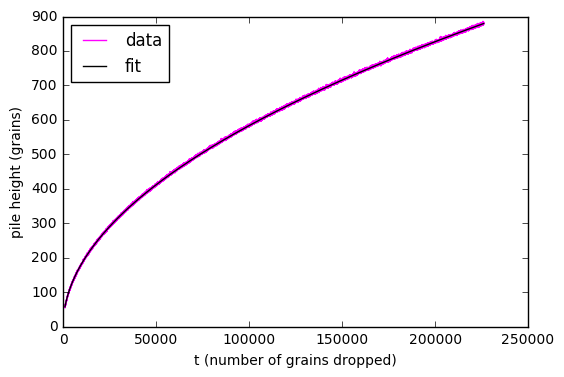

In [18]:
plt.plot(t, height_data, label='data', color='magenta')
plt.plot(t, power_law(t, a, p), label='fit', color='black')

plt.xlabel("t (number of grains dropped)")
plt.ylabel("pile height (grains)")
plt.legend(loc=0)
plt.show()

Perfect

# Task 2c

## Average Height vs. System Size
We can take the last 1,000,000 data points to calculate the average height at the steady state:

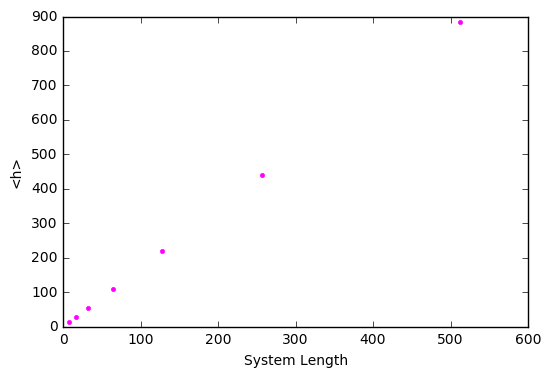

In [19]:
# Construct a dictionary to store the data points
system_lengths = list(data_dict.keys())
average_heights = [np.average(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]

plt.plot(system_lengths, average_heights, '.', color='magenta')

plt.xlabel("System Length")
plt.ylabel("<h>")
plt.show()

We see the line is not longer straight when system length is small. **finite size something??**  

We first try fit with first order correction:

In [20]:
get_average_pile_height_from_L = lambda L, a0, a1, w1: a0 * L * (1 - a1 * L ** (-w1))

(a0, a1, w1), cov = curve_fit(get_average_pile_height_from_L, system_lengths, average_heights, absolute_sigma=True)

a0, a1, w1, cov

(1.7341713154661471,
 0.23849160098376307,
 0.61270912276215195,
 array([[  1.91902053e-04,  -4.31036805e-03,  -6.05136926e-03],
        [ -4.31036805e-03,   1.28956563e-01,   1.60097176e-01],
        [ -6.05136926e-03,   1.60097176e-01,   2.09667386e-01]]))

$$\langle h \rangle = a_0L(1 - a_1L^{-w_1})$$  

where $a_0 = \langle z \rangle = 1.734$, $a_1 = 0.238,$ and $w_1 = 0.613$

Using the parameters, let's see how well the fit is:  

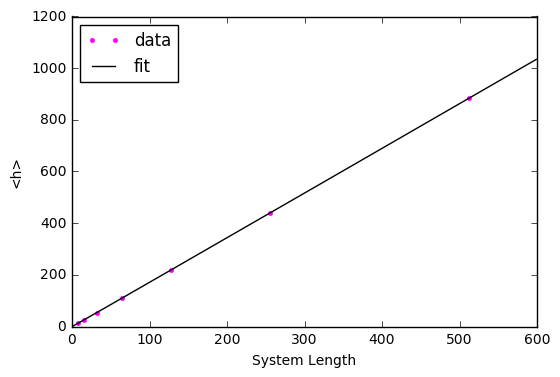

In [21]:
Ls = np.arange(1, 600)

plt.plot(system_lengths, average_heights, '.', color='magenta', label='data')
plt.plot(Ls, get_average_pile_height_from_L(Ls, a0, a1, w1), color='black', label='fit')

plt.xlabel("System Length")
plt.ylabel("<h>")
plt.legend(loc=0)
plt.show()

## Standard Deviation vs. System Size

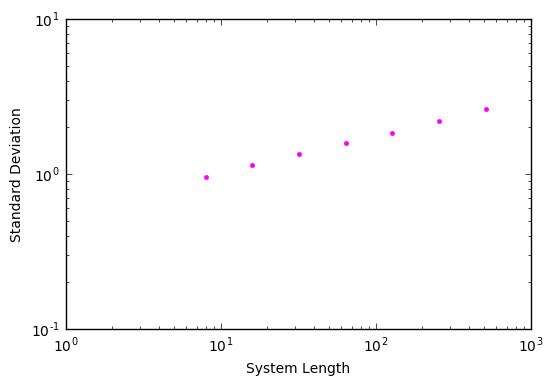

In [74]:
standard_deviations = [np.std(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]
plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')

plt.xlabel("System Length")
plt.ylabel("Standard Deviation")
plt.show()

Looks like a power law relation, so:

In [23]:
get_std_from_L = lambda L, a, w: a * L ** w

(a, w), cov = curve_fit(get_std_from_L, system_lengths, standard_deviations)

a, w, cov

(0.58065343512392253, 0.24062723662009047, array([[ 0.27920822, -0.09065535],
        [-0.09065535,  0.03117663]]))

$$\sigma_h(L)=aL^w$$  
where $a = 0.581$ and $w = 0.241$

Plotting on a loglog plot:

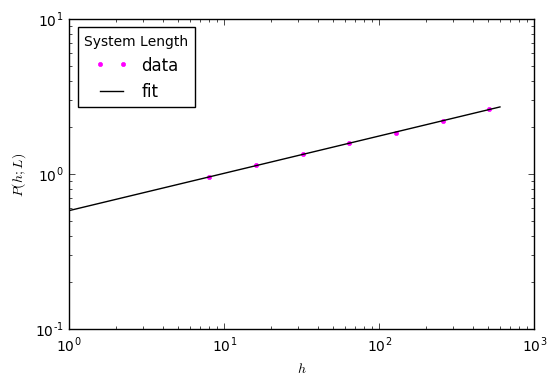

In [40]:
plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')
plt.loglog(Ls, get_std_from_L(Ls, a, w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("System Length")
plt.ylabel("Standard Deviation")
plt.show()

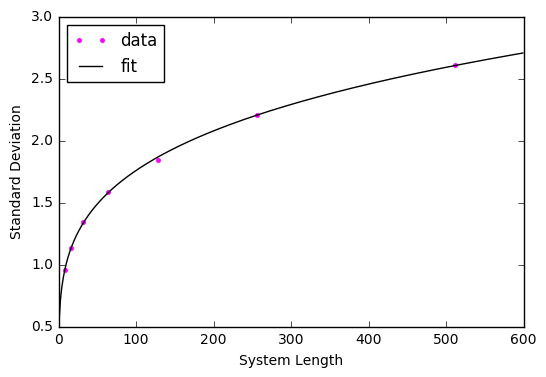

In [25]:
plt.plot(system_lengths, standard_deviations, '.', color='magenta', label='data')
plt.plot(Ls, get_std_from_L(Ls, a, w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("System Length")
plt.ylabel("Standard Deviation")
plt.show()

$$\sigma_z = \sigma_h / L \sim L^{w-1} \sim L^{-0.759}$$  

So the average slope's standard deviation tends to 0 in the limit of $L \rightarrow \infty$  


# Task 2d

**Plot height probability against height for the recurrent configurations:**

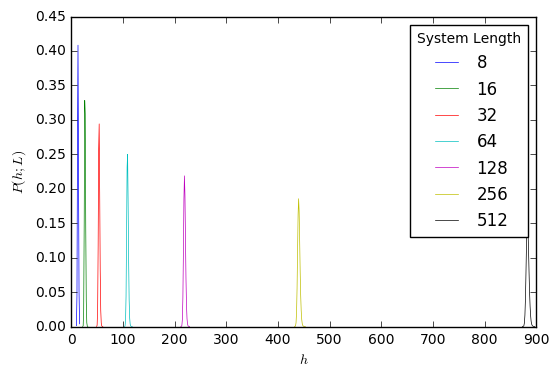

In [83]:
from importlib import reload
reload(analysis)
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    plt.plot(list(height_prob_dict.keys()), list(height_prob_dict.values()), '-', label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Length")
plt.xlabel("$h$")
plt.ylabel("$P(h; L)$")
plt.show()

Data collapse:

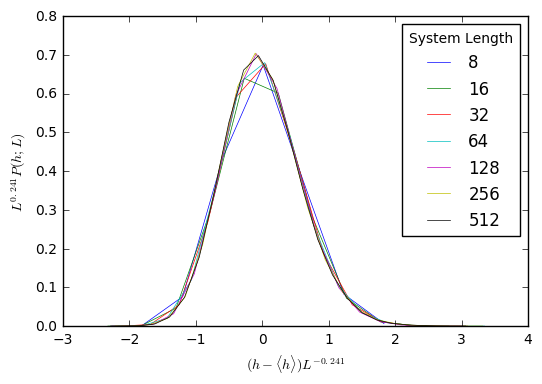

In [84]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    collapsed_h = (np.array(list(height_prob_dict.keys()))-average_heights[list(data_dict.keys()).index(length)]) / length ** w 
    collapsed_p = np.array(list(height_prob_dict.values())) * length ** w
    plt.plot(collapsed_h, collapsed_p, label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Length")
plt.xlabel(r"$(h - \langle h \rangle) L^{-0.241}$")
plt.ylabel("$L^{0.241}P(h; L)$")
plt.show()

$$$$

# Task 3a

## Avalanche size probability

Consider the system $L = 256$:

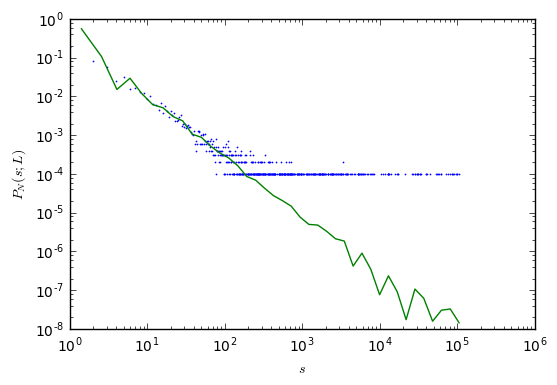

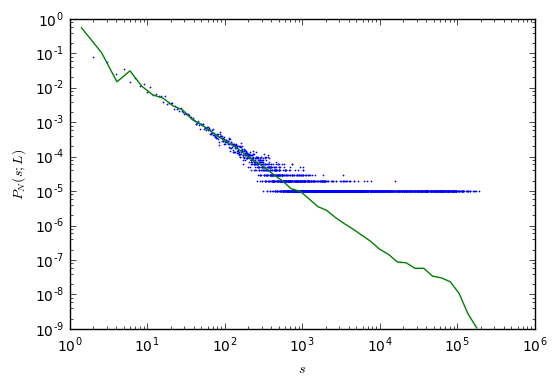

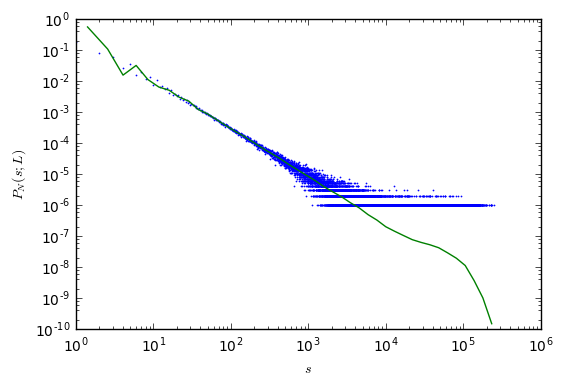

In [119]:
ava_size_256 = data_dict[256]['avalanche size']

no_of_samples = (10000, 100000, 1000000)

for i in no_of_samples:
    plt.figure()
    ava_size_prob_dict = analysis.calculate_avalanche_probability(ava_size_256[-i:])
    plt.loglog(list(ava_size_prob_dict.keys()), list(ava_size_prob_dict.values()), '.', ms=1.5, label=i)
    centres, probs = analysis.make_log_bins(ava_size_256[-i:], bin_scaling=1.3)
    plt.loglog(centres, probs, '-', label=i)
    plt.xlabel("$s$")
    plt.ylabel("$P_N(s;L)$")
    
# plt.legend(loc=0, title='Number of Samples')
plt.show()

$N$ needs to be large enough to see the cutoff effect.  
$a$ should be as small as possible, but the data points should produce a relatively smooth curve so we can analyse the trend.

# Task 3b

Choose $N=1,000,000$, plot the log-binned data for all system sizes:

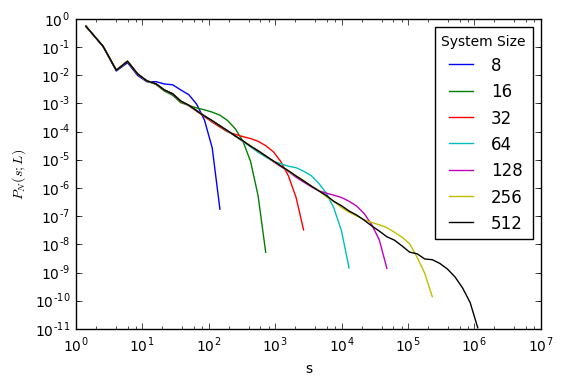

In [118]:
no_of_samples = 1000000

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'], bin_scaling=1.3)
    plt.loglog(centres, probabilities, '-', label=length)

plt.legend(loc=0, title='System Size')
plt.xlabel("$s$")
plt.ylabel("$P_N(s;L)$")
plt.show()

Chose $a=1.3$ to produce smooth curves and remove noise.

[INSERT QUALITATIVE DESCRIPTION]

# Task 3c

Plot the probability against avalanche size graph for $L = 512$:

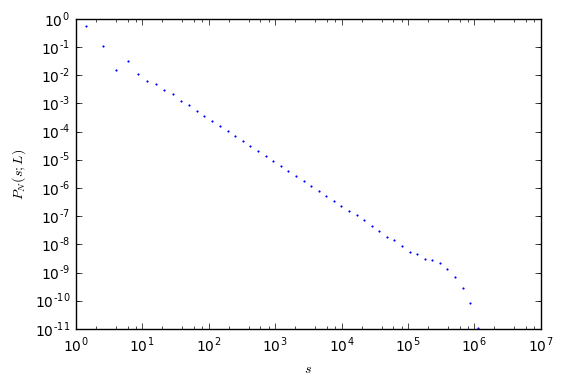

In [120]:
centres, probabilities = analysis.make_log_bins(data_dict[512]['avalanche size'], bin_scaling=1.3)
plt.loglog(centres, probabilities, '.', ms=2.0)
plt.xlabel("$s$")
plt.ylabel("$P_N(s;L)$")
plt.show()

We see that the data points follow a power law decay if we exclude the first and last 10 points.  

We can then fit it:

In [123]:
power_law = lambda s, a, tau_s: a * s ** tau_s

(a, tau_s), cov = curve_fit(power_law, centres[10:-10], probabilities[10:-10])

a, tau_s, cov

(0.40343536616369735,
 -1.571301343478541,
 array([[  1.64027624e-04,  -9.82225671e-05],
        [ -9.82225671e-05,   5.91528646e-05]]))

In [ ]:
plt.loglog(centres, probabilities, '.', ms=2.0)
plt.loglog()

plt.xlabel("$s$")
plt.ylabel("$P_N(s;L)$")
plt.show()